<a href="https://colab.research.google.com/github/phamtiensi/images-gallery/blob/main/vnpt_time_series1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
Author: Phalt
Email: phalt@vnpt.vn
```



# Data Processing

In [ ]:
!nvidia-smi

Sun Jun  5 04:00:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Preprocessing**

In [8]:
full_df = []
for item in os.listdir('/content/drive/MyDrive/lab/')[:]:
  csv_path = '/content/drive/MyDrive/lab/'+item
  df = pd.read_csv(csv_path)
  for col in df.columns.values.tolist()[2:]:
    df[col].fillna(df[col].mean(), inplace=True)
  if not df.isnull().values.any():
    full_df.append(df)
df_full = pd.concat(full_df)
len(full_df)

2

In [9]:
df_full.isnull().values.any()


False

In [10]:
col_name = df.columns.values.tolist()[1:]

In [11]:
col_name

['STA_DATETIME',
 'pmRrcConnEstabSucc',
 'pmRrcConnEstabAtt',
 'pmRrcConnEstabAttReatt',
 'pmS1SigConnEstabSucc',
 'pmS1SigConnEstabAtt',
 'pmErabEstabSuccInit',
 'pmErabEstabAttInit',
 'pmHoPrepSuccLteIntraF',
 'pmHoPrepAttLteIntraF',
 'pmHoExeSuccLteIntraF',
 'pmHoExeAttLteIntraF',
 'pmErabRelAbnormalEnbAct',
 'pmErabRelAbnormalMmeAct',
 'pmErabRelAbnormalEnb',
 'pmErabRelNormalEnb',
 'pmErabRelMme',
 'CSSR',
 'INTRA_FREQUENCY_HO',
 'SERVICE_DROP_ALL',
 'TRAFFIC',
 'USER_DL_AVG_THPUT']

In [12]:
train_full = []
val_full = []
test_full = []

for df in full_df:
  cols = col_name
  df = df[cols]
  date_time = pd.to_datetime(df.pop('STA_DATETIME'), format='%Y-%m-%d %H:%M:%S')
  
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  day = 24*60*60
  year = (365.2425)*day

  # df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  # df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
  # df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  # df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

  n = len(df)
  train_df = df[0:int(n*0.7)]
  val_df = df[int(n*0.7):int(n*0.9)]
  test_df = df[int(n*0.9):]

  train_full.append(train_df)
  val_full.append(val_df)
  test_full.append(test_df)

In [13]:
train_full_df = pd.concat(train_full)
train_mean = train_full_df.mean()
train_std = train_full_df.std()

In [ ]:
for index in range (len(train_full)):
  train_full[index] = (train_full[index] - train_mean) / train_std
  val_full[index] = (val_full[index] - train_mean) / train_std
  test_full[index] = (test_full[index] - train_mean) / train_std

**Labeling**

In [14]:
column_indices = {name: i for i, name in enumerate(train_full[0].columns)}

num_features = train_full[0].shape[1]
num_features

21

In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=None, val_df=None, test_df=None,
               label_columns=None):
    #Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}

    self.column_indices = {name: i for i, name in
                           enumerate(train_df[0].columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

  def plot(self, model=None, plot_col= None, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        print(inputs)
        predictions = model(inputs)
        print(predictions.shape)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, dataset):
    ds_dataset = None
    for data in dataset:
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

      ds = ds.map(self.split_window)
      if ds_dataset is None:
        ds_dataset = ds
      else:
        ds_dataset = ds_dataset.concatenate(ds)
    return ds_dataset

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# Warmup

**Train and Evaluation**

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['CSSR', 'INTRA_FREQUENCY_HO', 'SERVICE_DROP_ALL']

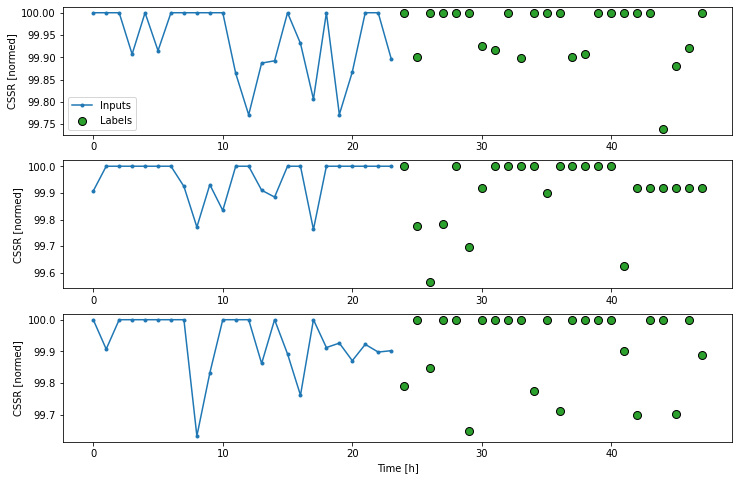

In [19]:
OUT_STEPS = 24  #'cssr',	'user_dl_avg_thput'	,'user_ul_avg_thput','traffic','intra_frequency_ho', 'service_drop_all'
label_columns = ['CSSR',
 'INTRA_FREQUENCY_HO',
 'SERVICE_DROP_ALL']

num_output = len(label_columns)

multi_window = WindowGenerator(input_width=24,
                               label_width= OUT_STEPS,
                               shift= 24,
                               train_df=train_full, test_df=test_full, val_df=val_full, label_columns= label_columns
                               ) #label_columns=['cssr', 'intra_frequency_ho','service_drop_all']

multi_window.plot(None,'CSSR')
multi_window

In [ ]:
multi_window.example[0].shape

TensorShape([32, 24, 19])

In [ ]:
multi_val_performance = {}
multi_performance = {}

In [17]:
train_full[0].head()

,pmRrcConnEstabSucc,pmRrcConnEstabAtt,pmRrcConnEstabAttReatt,pmS1SigConnEstabSucc,pmS1SigConnEstabAtt,pmErabEstabSuccInit,pmErabEstabAttInit,pmHoPrepSuccLteIntraF,pmHoPrepAttLteIntraF,pmHoExeSuccLteIntraF,...,pmErabRelAbnormalEnbAct,pmErabRelAbnormalMmeAct,pmErabRelAbnormalEnb,pmErabRelNormalEnb,pmErabRelMme,CSSR,INTRA_FREQUENCY_HO,SERVICE_DROP_ALL,TRAFFIC,USER_DL_AVG_THPUT
0,715.0,715.0,0.0,715.0,715.0,612.0,612.0,71.0,71.0,71.0,...,0.0,0.0,0.0,611.0,22.0,100.0,100.0,0.00000,1.06896,13018.92923
1,604.0,604.0,0.0,604.0,604.0,492.0,492.0,34.0,34.0,34.0,...,1.0,0.0,1.0,492.0,19.0,100.0,100.0,0.19531,0.81765,44462.06152
2,524.0,524.0,0.0,524.0,524.0,410.0,410.0,18.0,18.0,18.0,...,0.0,0.0,0.0,410.0,17.0,100.0,100.0,0.00000,0.38094,28898.27232
3,513.0,513.0,0.0,513.0,513.0,405.0,405.0,18.0,18.0,18.0,...,1.0,1.0,1.0,402.0,25.0,100.0,100.0,0.23364,0.27118,20816.61239
4,638.0,638.0,0.0,638.0,638.0,532.0,532.0,9.0,9.0,9.0,...,1.0,0.0,1.0,525.0,26.0,100.0,100.0,0.18116,0.48338,46380.15241


In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr*tf.math.exp(-0,1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
MAX_EPOCHS = 50

def custom_accuracy(y_true, y_pred, bias=0.05):
  return tf.keras.backend.mean(tf.abs(y_true - y_pred)/y_pred <= bias)

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='auto')
  opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer= opt,
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
  return history

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import array
import random
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout, Reshape
#from keras.optimizers import SGD
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from math import sqrt

# DeepAnT

In [ ]:
"""Hyperparameters"""
w = 24               # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 24*3          # Prediction window (number of time stampes required to be 
                         # predicted)
n_features = 19         # Univariate time series

kernel_size = 2          # Size of filter in conv layers
num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 32          # Number of filters in second conv layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w         # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

dropout_rate = 0.2       # Dropout rate in the fully connected layer

In [ ]:
"""Generate model for predictor"""
model = Sequential()

# Convolutional Layer #1
# Computes 32 features using a 1D filter(kernel) of with w with ReLU activation. 
# Padding is added to preserve width.
# Input Tensor Shape: [batch_size, w, 1] / batch_size = len(batch_sample)
# Output Tensor Shape: [batch_size, w, num_filt_1] (num_filt_1 = 32 feature vectors)
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))

# Pooling Layer #1
# First max pooling layer with a filter of length 2 and stride of 2
# Input Tensor Shape: [batch_size, w, num_filt_1]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1]

model.add(MaxPooling1D(pool_size=pool_size_1)) 
                    #  strides=pool_strides_1, 
                    #  padding='valid'))

# Convolutional Layer #2
# Computes 64 features using a 5x5 filter.
# Padding is added to preserve width and height.
# Input Tensor Shape: [batch_size, 0.5 * w, 32]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

# Max Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
# Input Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
model.add(MaxPooling1D(pool_size=pool_size_2))
                    #  strides=pool_strides_2, 
                    #  padding='valid'
          
# Flatten tensor into a batch of vectors
# Input Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
model.add(Flatten())

# Dense Layer (Output layer)
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 1024]
model.add(Dense(units=num_nrn_dl, activation='relu'))  

# Dropout
# Prevents overfitting in deep neural networks
model.add(Dropout(dropout_rate))

# Output layer
# Input Tensor Shape: [batch_size, 1024]
# Output Tensor Shape: [batch_size, p_w]
model.add(Dense(units=num_nrn_ol))
model.add(Reshape([24, 3]))

# Summarize model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 32)            1248      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 32)            2080      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 32)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 40)                6

In [ ]:
history = compile_and_fit(model, multi_window)

IPython.display.clear_output()

multi_val_performance['DeepAnT'] = model.evaluate(multi_window.val)
multi_performance['DeepAnT'] = model.evaluate(multi_window.test, verbose=0)

1957/1957 [==============================] - 25s 9ms/step - loss: 0.9193 - mean_absolute_error: 0.2512


(32, 24, 3)
(32, 24, 3)
(32, 24, 3)


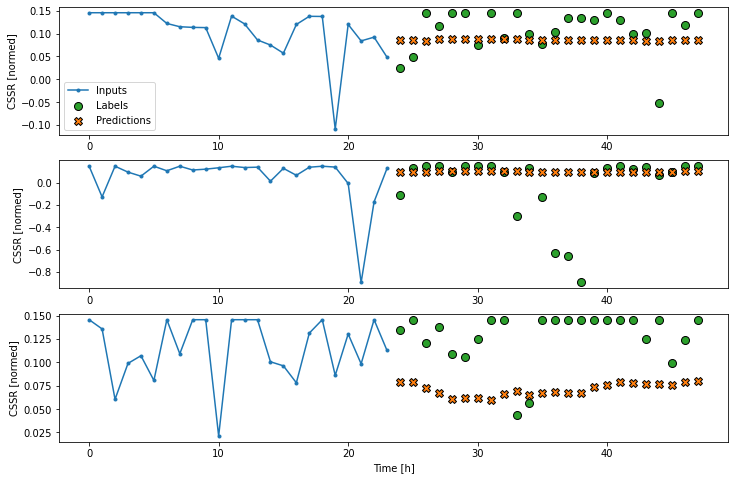

In [ ]:
multi_window.plot(model, 'CSSR')

(32, 24, 3)
(32, 24, 3)
(32, 24, 3)


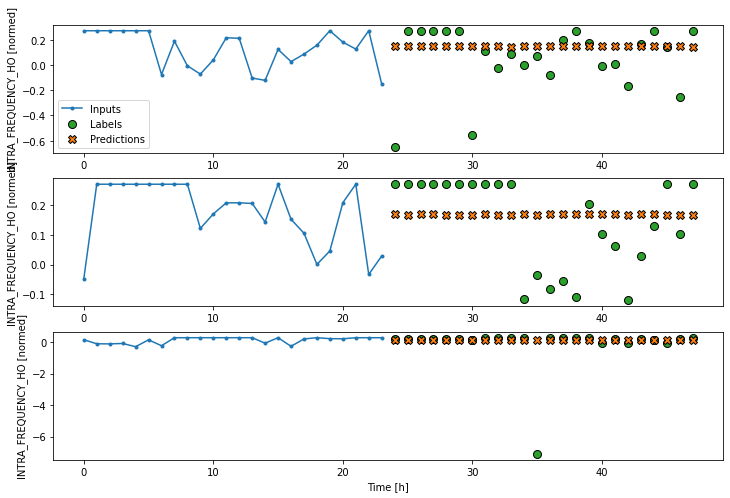

In [ ]:
multi_window.plot(model, 'INTRA_FREQUENCY_HO')

(32, 24, 3)
(32, 24, 3)
(32, 24, 3)


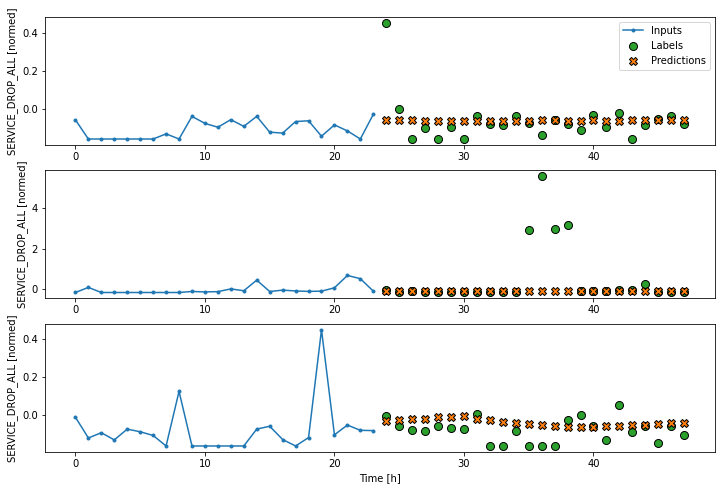

In [ ]:
multi_window.plot(model, 'SERVICE_DROP_ALL')

# LSTM 

**LSTM**

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(12,activation="relu"),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_output, activation='relu'),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_output])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

# New Section

# New Section

In [ ]:
multi_window.plot(multi_lstm_model, 'CSSR')

In [ ]:
multi_window.plot(multi_lstm_model, 'INTRA_FREQUENCY_HO')

In [ ]:
multi_window.plot(multi_lstm_model, 'SERVICE_DROP_ALL')

**AR LSTM**

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)


**Residual LSTM**

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
residual_multi_lstm_model = ResidualWrapper(
    tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(24, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_output,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_output])
]))

history = compile_and_fit(residual_multi_lstm_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Residual LSTM'] = residual_multi_lstm_model.evaluate(multi_window.val)
multi_performance['Residual LSTM'] = residual_multi_lstm_model.evaluate(multi_window.test, verbose=0)

In [ ]:
multi_window.plot(residual_multi_lstm_model, 'cssr')

Attention

In [ ]:
# Add attention layer to the deep learning network
class attention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = tf.keras.backend.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = tf.keras.backend.softmax(e)
        # Reshape to tensorFlow format
        alpha = tf.keras.backend.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = tf.keras.backend.sum(context, axis=1)
        return context

In [ ]:
def create_lstm_with_attention(hidden_units, dense_units, input_shape, activation):
    x= tf.keras.layers.Input(shape=input_shape)
    lstm_layer =  tf.keras.layers.LSTM (hidden_units, return_sequences=True, activation=activation)(x)
    attention_layer = attention()(lstm_layer)
    outputs=tf.keras.layers.Dense(dense_units*num_features, trainable=True,  kernel_initializer=tf.initializers.zeros()),  activation=activation)(attention_layer)
    model=tf.keras.Model(x,outputs)
    return model  

In [ ]:
multi_attention_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(24, return_sequences=False),
    attention(),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(multi_attention_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Attention LSTM'] = multi_attention_lstm_model.evaluate(multi_window.val)
multi_performance['Attention LSTM'] = multi_attention_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_attention_lstm_model, 'cssr')

***Loss Visualization***

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = feedback_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()